In [31]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import List
from IPython.display import clear_output

In [32]:
LETTERS = "qабвгдежзийклмнопрстуфхцчшщъыьэюяё"
VOWELS = "аеиоуэюяыё"
N_LETTERS = len(LETTERS)
MAX_WORD_LENGTH = 36

char2ind = {char: i for i, char in enumerate(LETTERS)}
ind2char = {i: char for char, i in char2ind.items()}

In [33]:
train = open('data/train_stresses_labels.txt', 'r', encoding="utf8").readlines()
for i in range(len(train)):
    train[i] = train[i][:-1]
train[:5]

['аа^к', 'аа^ка', 'аа^ке', 'аа^ки', 'аа^ков']

In [34]:
test = open('data/public_test_stresses.txt', 'r', encoding="utf8").readlines()
for i in range(len(test)):
    test[i] = test[i][:-1]
test[:5]

['аакам', 'ааками', 'ааленец', 'аама', 'аамами']

In [35]:
X, y = [], []
for i in tqdm(range(len(train))):
    X.append(train[i].replace('^', ''))
    correct_pos = train[i].find('^')
    y.append(correct_pos)
X[:5], y[:5]

 17%|█▋        | 102561/588490 [00:00<00:00, 1021201.67it/s]

100%|██████████| 588490/588490 [00:00<00:00, 1025593.43it/s]


(['аак', 'аака', 'ааке', 'ааки', 'ааков'], [2, 2, 2, 2, 2])

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)
# X_train, y_train = X, y

In [37]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [38]:
class CustomDataset:
    def __init__(self, X, y):
        self.data = []
        self.pad_id = char2ind['q']
        
        assert len(X) == len(y), "X and y must be same length"
        for word, label in zip(X, y):
            self.data.append({
                'word': word,
                'label': label
            })
        
    def __getitem__(self, idx: int) -> List[int]:
        preprocessed_word = [char2ind[char] for char in self.data[idx]['word']] 

        train_sample = {
            "text": preprocessed_word,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=char2ind['q'], max_len=MAX_WORD_LENGTH) -> torch.Tensor:
    words_lengths = [len(x['text']) for x in input_batch]
    max_word_length = min(max(words_lengths), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_word_length]
        for _ in range(max_word_length - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    words = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': words,
        'label': labels
    }

    return new_batch

In [39]:
train_files = CustomDataset(X_train, y_train)
val_files = CustomDataset(X_val, y_val)

batch_size = 128
train_loader = DataLoader(train_files, collate_fn=collate_fn_with_padding, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_files, collate_fn=collate_fn_with_padding, batch_size=batch_size, shuffle=False)

In [40]:
def evaluate(model, val_dataloader) -> float:
    model.eval()
    
    predictions = []
    target = []
    with torch.no_grad():
        for batch in val_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()
    
    model.train()
    return accuracy

In [41]:
def train(model, criterion, optimizer, num_epoch):
    losses = []
    acc = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        acc.append(evaluate(model, val_loader))
        losses.append(sum(epoch_losses) / len(epoch_losses))
        
        clear_output(True)
        print(f"Epoch #{epoch + 1}/{num_epoch} | loss: {losses[-1]} | acc: {acc[-1] * 100:.2f}")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.plot(np.arange(len(losses)), losses)
        ax1.set_title('Losses')
        ax1.set_xlabel("epoch")

        ax2.plot(np.arange(len(acc)), acc)
        ax2.set_title('Accuracy')
        ax2.set_xlabel("epoch")
        plt.show()

    return losses, acc

In [42]:
class RNN(nn.Module):
    def __init__(self, hidden_dim: int, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(N_LETTERS, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, N_LETTERS)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

Epoch #10/10 | loss: 0.21573082181955977 | acc: 91.38


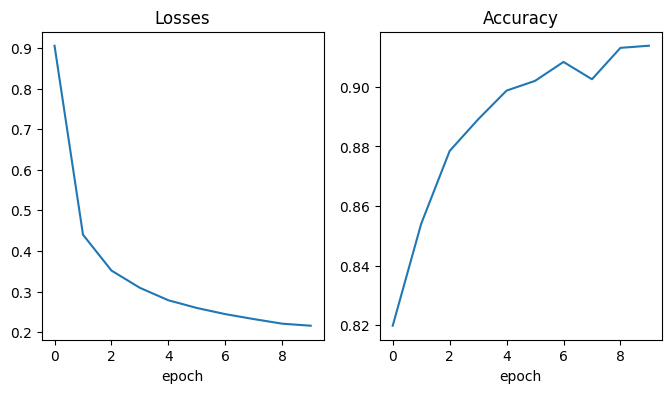

In [43]:
base_rnn = RNN(hidden_dim=256, aggregation_type='max').to(device)
max_predictions = train(
    base_rnn, 
    criterion=nn.CrossEntropyLoss(), 
    optimizer=torch.optim.Adam(base_rnn.parameters()),
    num_epoch=10
)

Epoch #10/10 | loss: 0.17973768387088765 | acc: 92.37


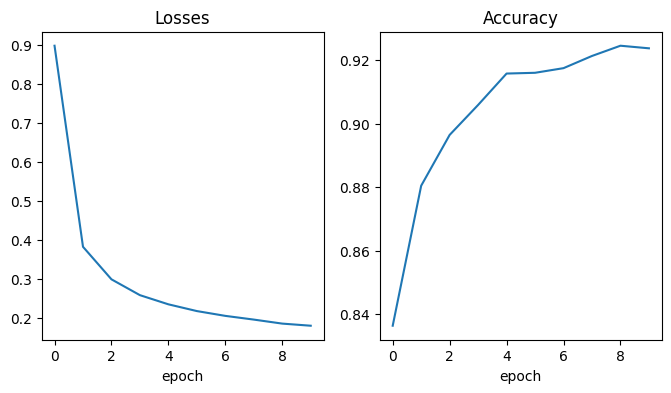

In [44]:
base_rnn_mean = RNN(hidden_dim=256, aggregation_type='mean').to(device)
mean_predictions = train(
    base_rnn_mean, 
    criterion=nn.CrossEntropyLoss(), 
    optimizer=torch.optim.Adam(base_rnn_mean.parameters()),
    num_epoch=10
)

In [45]:
def plot_two_aggregations(max_log, mean_log):
    loss_max, acc_max = max_log 
    loss_mean, acc_mean = mean_log 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(np.arange(len(loss_max)), loss_max, label='max')
    ax1.plot(np.arange(len(loss_mean)), loss_mean, label='mean')
    ax1.set_title('Losses')
    ax1.set_xlabel("epoch")
    ax1.legend()

    ax2.plot(np.arange(len(acc_max)), acc_max, label='max')
    ax2.plot(np.arange(len(acc_mean)), acc_mean, label='mean')
    ax2.set_title('Accuracy')
    ax2.set_xlabel("epoch")
    ax2.legend()
    plt.show()

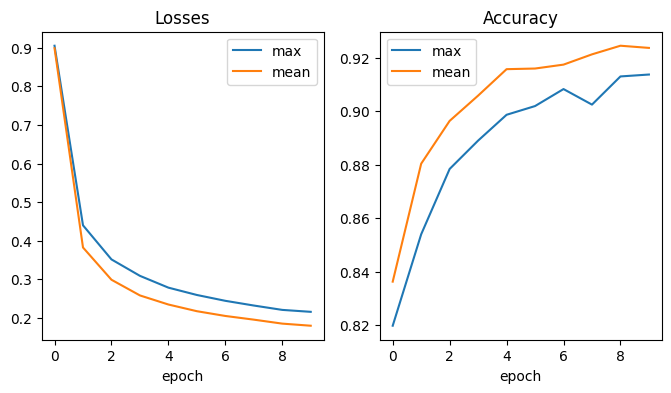

In [46]:
plot_two_aggregations(max_predictions, mean_predictions)

In [47]:
X_test = test
y_test = range(len(X_test))

base_rnn_mean.eval()

test_files = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_files, collate_fn=collate_fn_with_padding, batch_size=128, shuffle=False)

res = [0] * len(y_test)

for batch in test_loader:
    with torch.no_grad():
        logits = base_rnn_mean(batch['input_ids'])
        preds = torch.argmax(logits, 1)
        
        # print(batch['input_ids'])
        # print(preds)
        # print(batch['label'])
        # break
        
        for prediction, pos in zip(preds, batch['label']):
            res[pos] = prediction.item()

res[:5]

[2, 2, 4, 2, 2]

In [48]:
with open('rnn_predictions.txt', 'w', encoding="utf8") as f:
    for i, x in enumerate(res):
        x -= 1
        f.write(f"{test[i][:x + 1]}^{test[i][x + 1:]}\n")